# Base model
**https://www.kaggle.com/code/ammfat/facial-emotion-recognition-vgg16-fer2013/notebook**

In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
# Load the trained model
model_vgg16 = load_model('/kaggle/input/my-dataset-pretrain-facial-emotion-recognition/VGG16_trainable_parameter.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [3]:
# Print the model summary to inspect the layers, input shape, and output shape
model_vgg16.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,281 (56.15 MB)

 Trainable params: 14,718,279 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Reading test set for both model

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import time
from tqdm import tqdm

# Định nghĩa các class
class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Đường dẫn đến thư mục test
test_dir = '/kaggle/input/fer2013/test'

# Calculate performance for VGG model

In [5]:
def evaluate_class(class_folder, model):
    # Đường dẫn đến thư mục của class
    folder_path = os.path.join(test_dir, class_folder)
    
    # Lấy danh sách các file ảnh
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    correct_predictions = 0
    total_time = 0
    predictions_list = []
    
    # Xử lý từng ảnh
    for img_file in tqdm(image_files, desc=f"Processing {class_folder}"):
        img_path = os.path.join(folder_path, img_file)
        
        # Đọc và tiền xử lý ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))
        
        # Chuyển grayscale thành RGB bằng cách stack 3 kênh
        img_rgb = np.stack((img,)*3, axis=-1)
        
        img_array = image.img_to_array(img_rgb)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # Normalize pixel values
        
        # Đo thời gian inference
        start_time = time.time()
        predictions = model.predict(img_array, verbose=0)
        end_time = time.time()
        
        total_time += (end_time - start_time)
        
        # Lấy class được dự đoán
        predicted_class = class_names[np.argmax(predictions)]
        predictions_list.append(predicted_class)
        
        # Kiểm tra dự đoán đúng
        if predicted_class == class_folder:
            correct_predictions += 1
    
    # Tính toán các metrics
    n_samples = len(image_files)
    accuracy = correct_predictions / n_samples if n_samples > 0 else 0
    avg_time = total_time / n_samples if n_samples > 0 else 0
    
    return {
        'class': class_folder,
        'n_samples': n_samples,
        'accuracy': accuracy,
        'avg_inference_time': avg_time,
        'total_time': total_time
    }


In [6]:
# Đánh giá từng class và lưu kết quả
results = []
for class_name in class_names:
    result = evaluate_class(class_name, model_vgg16)
    results.append(result)
    print(f"\nResults for {class_name}:")
    print(f"Number of samples: {result['n_samples']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Average inference time: {result['avg_inference_time']*1000:.2f} ms")

# Tính toán metrics tổng thể
total_samples = sum(r['n_samples'] for r in results)
weighted_accuracy = sum(r['accuracy'] * r['n_samples'] for r in results) / total_samples
weighted_avg_time = sum(r['total_time'] for r in results) / total_samples

print("\nOverall Results:")
print("Class-wise results:")
for r in results:
    print(f"{r['class']}: Accuracy = {r['accuracy']:.4f}, "
          f"Avg Time = {r['avg_inference_time']*1000:.2f} ms, "
          f"Samples = {r['n_samples']}")

print(f"\nWeighted Average Accuracy: {weighted_accuracy:.4f}")
print(f"Average Inference Time per Image: {weighted_avg_time*1000:.2f} ms")

# Tạo DataFrame để hiển thị kết quả
results_df = pd.DataFrame(results)
print("\nDetailed Results DataFrame:")
print(results_df)

Processing angry:   0%|          | 0/958 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1731311225.262502      97 service.cc:145] XLA service 0x7d1244002420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731311225.262559      97 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731311225.262566      97 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731311227.312866      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing angry: 100%|██████████| 958/958 [01:07<00:00, 14.29it/s]



Results for angry:
Number of samples: 958
Accuracy: 0.8100
Average inference time: 61.15 ms


Processing disgust: 100%|██████████| 111/111 [00:07<00:00, 15.34it/s]



Results for disgust:
Number of samples: 111
Accuracy: 0.9009
Average inference time: 59.57 ms


Processing fear: 100%|██████████| 1024/1024 [01:06<00:00, 15.30it/s]



Results for fear:
Number of samples: 1024
Accuracy: 0.7539
Average inference time: 59.12 ms


Processing happy: 100%|██████████| 1774/1774 [01:59<00:00, 14.83it/s]



Results for happy:
Number of samples: 1774
Accuracy: 0.9566
Average inference time: 59.99 ms


Processing sad: 100%|██████████| 1247/1247 [01:27<00:00, 14.21it/s]



Results for sad:
Number of samples: 1247
Accuracy: 0.7506
Average inference time: 60.78 ms


Processing surprise: 100%|██████████| 831/831 [00:58<00:00, 14.19it/s]



Results for surprise:
Number of samples: 831
Accuracy: 0.8809
Average inference time: 60.21 ms


Processing neutral: 100%|██████████| 1233/1233 [01:24<00:00, 14.63it/s]



Results for neutral:
Number of samples: 1233
Accuracy: 0.8597
Average inference time: 59.92 ms

Overall Results:
Class-wise results:
angry: Accuracy = 0.8100, Avg Time = 61.15 ms, Samples = 958
disgust: Accuracy = 0.9009, Avg Time = 59.57 ms, Samples = 111
fear: Accuracy = 0.7539, Avg Time = 59.12 ms, Samples = 1024
happy: Accuracy = 0.9566, Avg Time = 59.99 ms, Samples = 1774
sad: Accuracy = 0.7506, Avg Time = 60.78 ms, Samples = 1247
surprise: Accuracy = 0.8809, Avg Time = 60.21 ms, Samples = 831
neutral: Accuracy = 0.8597, Avg Time = 59.92 ms, Samples = 1233

Weighted Average Accuracy: 0.8461
Average Inference Time per Image: 60.17 ms

Detailed Results DataFrame:
      class  n_samples  accuracy  avg_inference_time  total_time
0     angry        958  0.810021            0.061149   58.581220
1   disgust        111  0.900901            0.059575    6.612817
2      fear       1024  0.753906            0.059125   60.543978
3     happy       1774  0.956595            0.059989  106.420944

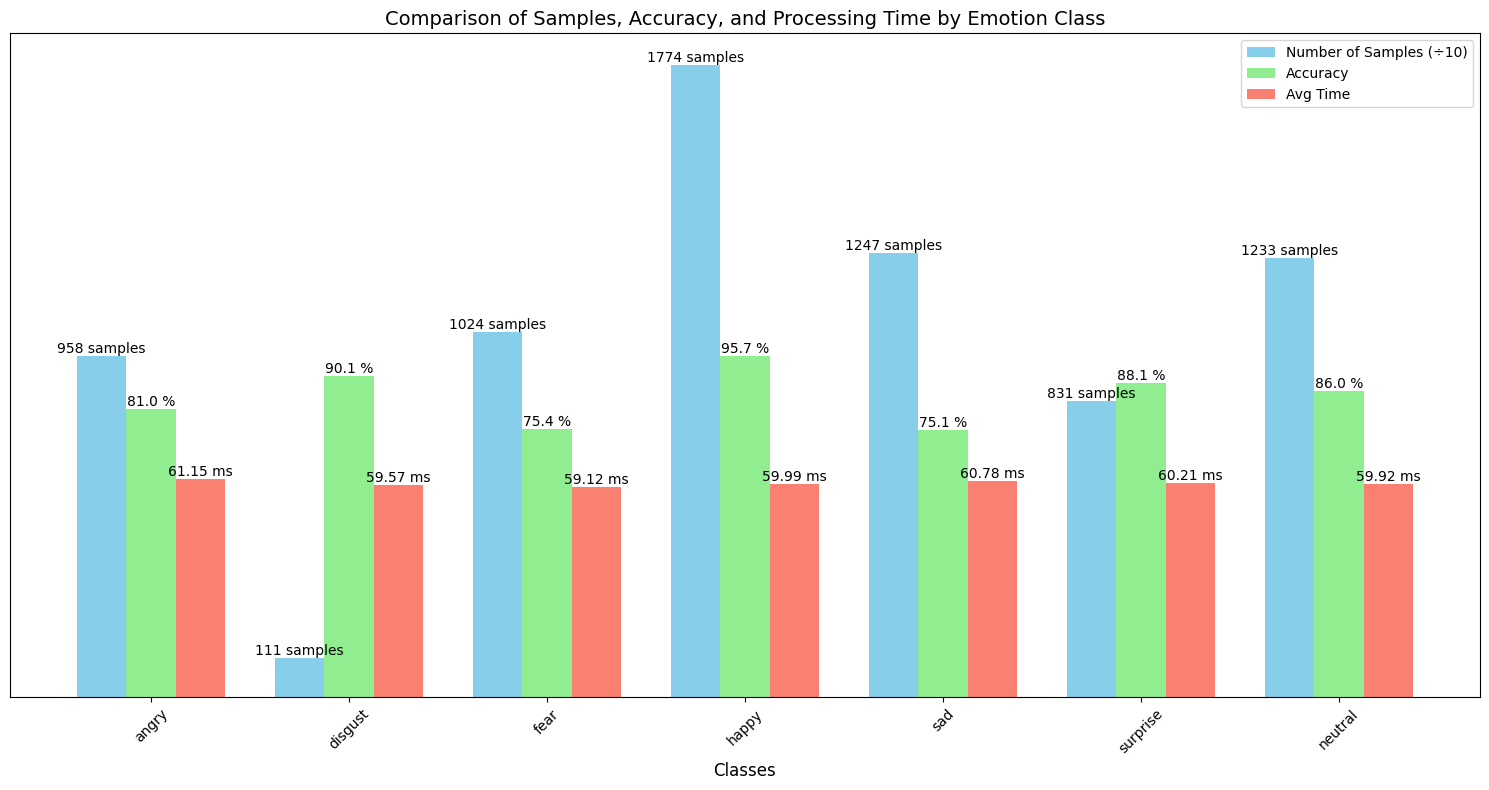

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Chuẩn bị dữ liệu
classes = results_df['class']
n_samples = results_df['n_samples'] / 10  # Scale down số lượng mẫu
accuracies = results_df['accuracy'] * 100
avg_times = results_df['avg_inference_time'] * 1000

# Tạo vị trí cho các cột
x = np.arange(len(classes))
width = 0.25

# Tạo figure
plt.figure(figsize=(15, 8))

# Tạo các cột
bars1 = plt.bar(x - width, n_samples, width, label='Number of Samples (÷10)', color='skyblue')
bars2 = plt.bar(x, accuracies, width, label='Accuracy', color='lightgreen')
bars3 = plt.bar(x + width, avg_times, width, label='Avg Time', color='salmon')

# Thêm giá trị và đơn vị lên từng cột
def autolabel(bars, values, format_str):
    for bar, val in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                format_str.format(val),
                ha='center', va='bottom')

# Hiển thị giá trị gốc (chưa scale) cho số lượng mẫu
autolabel(bars1, results_df['n_samples'], '{:.0f} samples')
autolabel(bars2, accuracies, '{:.1f} %')
autolabel(bars3, avg_times, '{:.2f} ms')

# Tùy chỉnh đồ thị
plt.xlabel('Classes', fontsize=12)
plt.title('Comparison of Samples, Accuracy, and Processing Time by Emotion Class', fontsize=14)
plt.xticks(x, classes, rotation=45)
plt.legend()

# Xóa label trục y và ẩn các đường kẻ của trục y
plt.ylabel('')
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Thêm grid để dễ đọc (chỉ theo chiều ngang)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Tự động điều chỉnh layout
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

# Define my model

## 1. Reading training set

**This training set used for both VGG model and my model**<br>
**You can read the training VGG model notebook here 'https://www.kaggle.com/code/ammfat/facial-emotion-recognition-vgg16-fer2013/notebook'**

In [8]:
import math
import numpy as np
import pandas as pd

import cv2
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [9]:
df = pd.read_csv('/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
df =df[['emotion','pixels']]
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [11]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [12]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
counts = df.emotion.value_counts()
# Tạo Series value_counts
counts = df.emotion.value_counts()

# Tạo DataFrame mới với index từ 0-6
count_df = pd.DataFrame({
    'label': [emotion_label_to_text[i] for i in range(7)],
    'count': [counts.get(i, 0) for i in range(7)]
})

# Thêm cột index
count_df.index.name = 'index'

# Hiển thị bảng
print(count_df)

           label  count
index                  
0          anger   4953
1        disgust    547
2           fear   5121
3      happiness   8989
4        sadness   6077
5       surprise   4002
6        neutral   6198


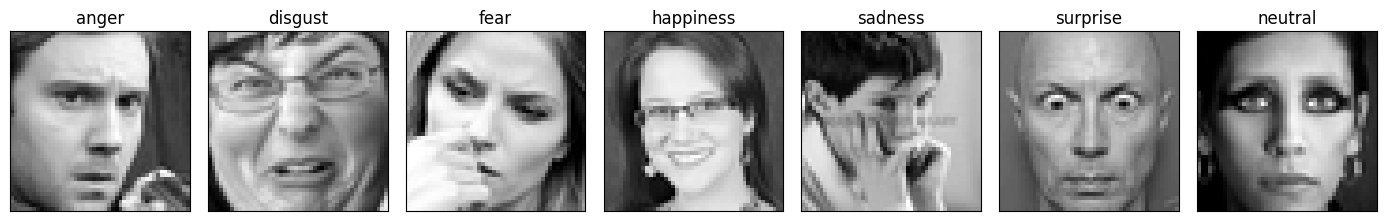

In [13]:
import numpy as np
from matplotlib import pyplot as plt

def plot_one_image_per_emotion(df, emotion_label_to_text):
    fig = plt.figure(figsize=(14, 14))
    unique_labels = sorted(df.emotion.unique())  # Lấy tất cả nhãn unique

    for i, label in enumerate(unique_labels, 1):  # Duyệt từng nhãn, bắt đầu index từ 1
        # Lấy ảnh đầu tiên của mỗi nhãn
        px = df[df.emotion == label].pixels.iloc[0]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        ax = fig.add_subplot(7, 7, i)  # Thêm subplot vào vị trí i
        ax.imshow(px, cmap='gray')     # Hiển thị ảnh
        ax.set_xticks([])              # Bỏ ticks x
        ax.set_yticks([])              # Bỏ ticks y
        ax.set_title(emotion_label_to_text[label])  # Đặt tiêu đề theo nhãn

    plt.tight_layout()
    plt.show()
plot_one_image_per_emotion(df, emotion_label_to_text)

In [14]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)
img_array.shape

(35887, 48, 48)

In [15]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)
img_array = img_features

(35887, 48, 48, 3)


In [16]:
print(df['emotion'].shape)

(35887,)


In [17]:
type(img_array)

numpy.ndarray

## 2. Train/val split

In [18]:
X = img_array
y = df['emotion'].values

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)

In [20]:

print(f"Train set shape: \n X: {X_train.shape} \n y: {y_train.shape}")
print(f"Validation set shape: \n X: {X_val.shape}\n y: {y_val.shape}")

Train set shape: 
 X: (28709, 48, 48, 3) 
 y: (28709,)
Validation set shape: 
 X: (7178, 48, 48, 3)
 y: (7178,)


In [21]:
X_train /= 255.0
X_val /= 255.0

In [22]:
# Create a dictionary to store label counts
label_train_counts = {}
label_val_counts = {}

# Iterate through the labels in the training set
for label in y_train:
    if label in label_train_counts:
        label_train_counts[label] += 1
    else:
        label_train_counts[label] = 1

# Do the same for the validation set
for label in y_val:
    if label in label_val_counts:
        label_val_counts[label] += 1
    else:
        label_val_counts[label] = 1

for i in range(7):
    print(f'{i} label in train set - {label_train_counts[i]}\n {i} label in val set - {label_val_counts[i]}')


0 label in train set - 3931
 0 label in val set - 1022
1 label in train set - 428
 1 label in val set - 119
2 label in train set - 4136
 2 label in val set - 985
3 label in train set - 7195
 3 label in val set - 1794
4 label in train set - 4828
 4 label in val set - 1249
5 label in train set - 3250
 5 label in val set - 752
6 label in train set - 4941
 6 label in val set - 1257


In [23]:
import numpy as np
import tensorflow as tf
num_classes =len(emotion_label_to_text)
# Chuyển đổi nhãn y thành dạng one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
print("Shape of y_train data:", y_train.shape)
print("Shape of y_val data:", y_val.shape)



Shape of y_train data: (28709, 7)
Shape of y_val data: (7178, 7)


In [24]:

# Tạo TensorFlow Dataset từ numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)


# Print shape of the first batch in train_dataset
for X_batch, y_batch in train_dataset.take(1):
    print("Train batch shape:", X_batch.shape)
    print("Train labels shape:", y_batch.shape)
    print("Train sample labels:", y_batch[:1].numpy())

# Print shape of the first batch in val_dataset
for X_batch, y_batch in val_dataset.take(1):
    print("Validation batch shape:", X_batch.shape)
    print("Validation labels shape:", y_batch.shape)
    print("Validation sample labels:", y_batch[:1].numpy())

Train batch shape: (32, 48, 48, 3)
Train labels shape: (32, 7)
Train sample labels: [[0. 0. 0. 0. 1. 0. 0.]]
Validation batch shape: (32, 48, 48, 3)
Validation labels shape: (32, 7)
Validation sample labels: [[0. 0. 0. 0. 1. 0. 0.]]


## 3. Define model

## Version 1 (overfit)

In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Tải mô hình ResNet-50 với các trọng số đã được huấn luyện trước trên ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
num_classes =len(emotion_label_to_text)

# Thêm các lớp đầu ra phù hợp với bài toán của bạn
x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)  # New layer
x = Dense(64, activation='relu')(x)  # New layer

predictions = Dense(num_classes, activation='softmax')(x)  # num_classes là số lượng cảm xúc

# Tạo mô hình hoàn chỉnh
model = Model(inputs=base_model.input, outputs=predictions)

# Đóng băng các lớp của mô hình gốc để không huấn luyện lại chúng
for layer in base_model.layers:
    layer.trainable = True

# Biên dịch mô hình
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# In cấu trúc mô hình
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 25,965,191 (99.05 MB)

 Trainable params: 25,912,071 (98.85 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [26]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size=32,  # Specify batch size if not set in dataset
    shuffle=True,  # Shuffle the training data before each epoch
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_checkpoint.keras", save_best_only=True)
    ],
    verbose=2  # Adjust verbosity (0, 1, or 2) for logging output during training
)


Epoch 1/10
898/898 - 114s - 127ms/step - accuracy: 0.4407 - loss: 1.4410 - val_accuracy: 0.4685 - val_loss: 1.3923
Epoch 2/10
898/898 - 39s - 43ms/step - accuracy: 0.5999 - loss: 1.0529 - val_accuracy: 0.5607 - val_loss: 1.2358
Epoch 3/10
898/898 - 37s - 41ms/step - accuracy: 0.7186 - loss: 0.7563 - val_accuracy: 0.5465 - val_loss: 1.4748
Epoch 4/10
898/898 - 37s - 41ms/step - accuracy: 0.8028 - loss: 0.5402 - val_accuracy: 0.5157 - val_loss: 1.7919
Epoch 5/10
898/898 - 37s - 41ms/step - accuracy: 0.8627 - loss: 0.3862 - val_accuracy: 0.5680 - val_loss: 2.0190
Epoch 6/10
898/898 - 37s - 41ms/step - accuracy: 0.9007 - loss: 0.2747 - val_accuracy: 0.5492 - val_loss: 2.7301
Epoch 7/10
898/898 - 37s - 41ms/step - accuracy: 0.9273 - loss: 0.2103 - val_accuracy: 0.5737 - val_loss: 2.1278
Epoch 8/10
898/898 - 37s - 41ms/step - accuracy: 0.9384 - loss: 0.1823 - val_accuracy: 0.5839 - val_loss: 2.1053
Epoch 9/10
898/898 - 37s - 41ms/step - accuracy: 0.9482 - loss: 0.1527 - val_accuracy: 0.5666 

In [27]:
model.save("model.h5")

In [28]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

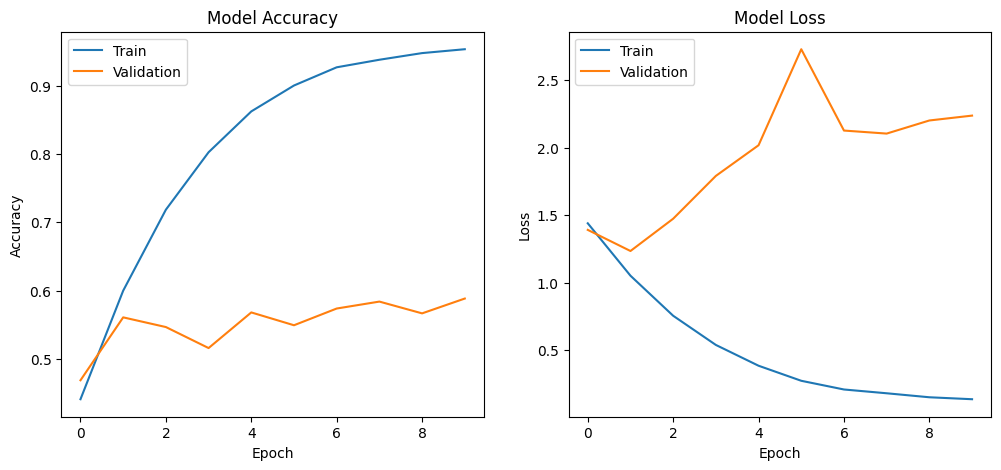

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Version 2 (overfit)

In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Tải mô hình ResNet-50 với các trọng số đã được huấn luyện trước trên ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
num_classes =len(emotion_label_to_text)

# Thêm các lớp đầu ra phù hợp với bài toán của bạn
x = base_model.output
# chuyển đổi ouput -> 1D
x = GlobalAveragePooling2D()(x)


x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)  # New layer
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)  # New layer
x = Dropout(0.3)(x)

predictions = Dense(num_classes, activation='softmax')(x)  # num_classes là số lượng cảm xúc

# Tạo mô hình hoàn chỉnh
model = Model(inputs=base_model.input, outputs=predictions)

# Đóng băng các lớp của mô hình gốc để không huấn luyện lại chúng
for layer in base_model.layers[-3:]:
    layer.trainable = True

# Biên dịch mô hình
model.compile(
    optimizer=Adam(learning_rate=1e-6,amsgrad=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# In cấu trúc mô hình
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 25,965,191 (99.05 MB)

 Trainable params: 25,912,071 (98.85 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    batch_size=32,  # Specify batch size if not set in dataset
    shuffle=True,  # Shuffle the training data before each epoch
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_checkpoint.keras", save_best_only=True)
    ],
    verbose=2  # Adjust verbosity (0, 1, or 2) for logging output during training
)


Epoch 1/100
898/898 - 133s - 148ms/step - accuracy: 0.1695 - loss: 2.4547 - val_accuracy: 0.2067 - val_loss: 5.4448
Epoch 2/100
898/898 - 44s - 49ms/step - accuracy: 0.1849 - loss: 2.2396 - val_accuracy: 0.2243 - val_loss: 2.2882
Epoch 3/100
898/898 - 81s - 91ms/step - accuracy: 0.2037 - loss: 2.1124 - val_accuracy: 0.2406 - val_loss: 2.2754
Epoch 4/100


In [ ]:
import matplotlib.pyplot as plt
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
                                                                                            
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Version 3

**Apply data agumentation**

In [33]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [34]:

# Tạo TensorFlow Dataset từ numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)


# Print shape of the first batch in train_dataset
for X_batch, y_batch in train_dataset.take(1):
    print("Train batch shape:", X_batch.shape)
    print("Train labels shape:", y_batch.shape)
    print("Train sample labels:", y_batch[:1].numpy())

# Print shape of the first batch in val_dataset
for X_batch, y_batch in val_dataset.take(1):
    print("Validation batch shape:", X_batch.shape)
    print("Validation labels shape:", y_batch.shape)
    print("Validation sample labels:", y_batch[:1].numpy())

Train batch shape: (32, 48, 48, 3)
Train labels shape: (32, 7)
Train sample labels: [[0. 0. 0. 0. 1. 0. 0.]]
Validation batch shape: (32, 48, 48, 3)
Validation labels shape: (32, 7)
Validation sample labels: [[0. 0. 0. 0. 1. 0. 0.]]


In [35]:
num_classes

7

In [36]:
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import (
    AveragePooling2D,
    Conv2D,
    MaxPooling2D,
    Activation,
    Flatten,
    Dense
)

In [48]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Add
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut connection
    shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_initializer='he_uniform')(x)
    shortcut = BatchNormalization()(shortcut)
    
    # Main path
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    
    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

input_shape = (48, 48, 3)
inputs = Input(shape=input_shape)

# Initial Conv Layer
x = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Residual Blocks
x = residual_block(x, 32)
x = AveragePooling2D(pool_size=(2, 2))(x)

x = residual_block(x, 64)
x = AveragePooling2D(pool_size=(2, 2))(x)

x = residual_block(x, 128)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 48, 48,    │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         64 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 24, 24,    │          0 │ activation_9[0][… │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 24, 24,    │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 24, 24,    │      9,248 │ activation_10[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 24, 24,    │        544 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 24, 24,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_4 │ (None, 12, 12,    │          0 │ activation_11[0]… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 12, 12,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ conv2d_12[0][0] 

 Total params: 456,871 (1.74 MB)

 Trainable params: 455,495 (1.74 MB)

 Non-trainable params: 1,376 (5.38 KB)

In [49]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6 ,amsgrad=True),
    metrics=['accuracy']
)

In [50]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=32,
    epochs=300,
    verbose = 2,
    shuffle=True,  # Determine whether to shuffle the training data before each epoch
)

Epoch 1/300


I0000 00:00:1731294591.320930      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_40', 8 bytes spill stores, 8 bytes spill loads



898/898 - 26s - 29ms/step - accuracy: 0.1930 - loss: 1.9946 - val_accuracy: 0.2145 - val_loss: 1.9035
Epoch 2/300
898/898 - 6s - 6ms/step - accuracy: 0.2318 - loss: 1.8664 - val_accuracy: 0.2320 - val_loss: 1.8467
Epoch 3/300
898/898 - 5s - 6ms/step - accuracy: 0.2431 - loss: 1.8292 - val_accuracy: 0.2446 - val_loss: 1.8181
Epoch 4/300
898/898 - 5s - 6ms/step - accuracy: 0.2551 - loss: 1.8066 - val_accuracy: 0.2570 - val_loss: 1.7991
Epoch 5/300
898/898 - 5s - 6ms/step - accuracy: 0.2640 - loss: 1.7900 - val_accuracy: 0.2643 - val_loss: 1.7846
Epoch 6/300
898/898 - 10s - 12ms/step - accuracy: 0.2713 - loss: 1.7768 - val_accuracy: 0.2699 - val_loss: 1.7729
Epoch 7/300
898/898 - 5s - 6ms/step - accuracy: 0.2770 - loss: 1.7655 - val_accuracy: 0.2767 - val_loss: 1.7628
Epoch 8/300
898/898 - 5s - 6ms/step - accuracy: 0.2832 - loss: 1.7554 - val_accuracy: 0.2806 - val_loss: 1.7539
Epoch 9/300
898/898 - 5s - 6ms/step - accuracy: 0.2878 - loss: 1.7464 - val_accuracy: 0.2871 - val_loss: 1.7459


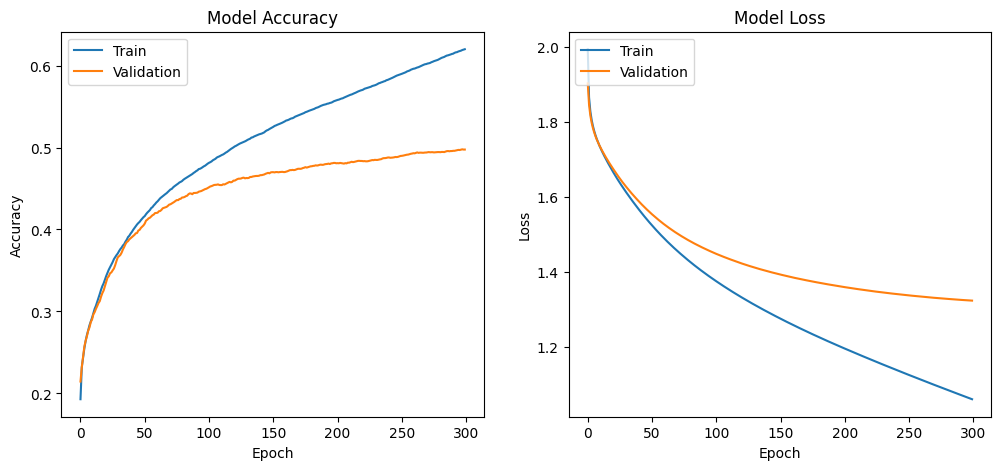

In [51]:
import matplotlib.pyplot as plt
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
                                                                                            
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [52]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import time
from tqdm import tqdm

# Định nghĩa các class
class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Đường dẫn đến thư mục test
test_dir = '/kaggle/input/fer2013/test'

In [53]:
def evaluate_class(class_folder, model):
    # Đường dẫn đến thư mục của class
    folder_path = os.path.join(test_dir, class_folder)
    
    # Lấy danh sách các file ảnh
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    correct_predictions = 0
    total_time = 0
    predictions_list = []
    
    # Xử lý từng ảnh
    for img_file in tqdm(image_files, desc=f"Processing {class_folder}"):
        img_path = os.path.join(folder_path, img_file)
        
        # Đọc và tiền xử lý ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))
        
        # Chuyển grayscale thành RGB bằng cách stack 3 kênh
        img_rgb = np.stack((img,)*3, axis=-1)
        
        img_array = image.img_to_array(img_rgb)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # Normalize pixel values
        
        # Đo thời gian inference
        start_time = time.time()
        predictions = model.predict(img_array, verbose=0)
        end_time = time.time()
        
        total_time += (end_time - start_time)
        
        # Lấy class được dự đoán
        predicted_class = class_names[np.argmax(predictions)]
        predictions_list.append(predicted_class)
        
        # Kiểm tra dự đoán đúng
        if predicted_class == class_folder:
            correct_predictions += 1
    
    # Tính toán các metrics
    n_samples = len(image_files)
    accuracy = correct_predictions / n_samples if n_samples > 0 else 0
    avg_time = total_time / n_samples if n_samples > 0 else 0
    
    return {
        'class': class_folder,
        'n_samples': n_samples,
        'accuracy': accuracy,
        'avg_inference_time': avg_time,
        'total_time': total_time
    }


In [ ]:
# Đánh giá từng class và lưu kết quả
results = []
for class_name in class_names:
    result = evaluate_class(class_name, model)
    results.append(result)
    print(f"\nResults for {class_name}:")
    print(f"Number of samples: {result['n_samples']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Average inference time: {result['avg_inference_time']*1000:.2f} ms")

# Tính toán metrics tổng thể
total_samples = sum(r['n_samples'] for r in results)
weighted_accuracy = sum(r['accuracy'] * r['n_samples'] for r in results) / total_samples
weighted_avg_time = sum(r['total_time'] for r in results) / total_samples

print("\nOverall Results:")
print("Class-wise results:")
for r in results:
    print(f"{r['class']}: Accuracy = {r['accuracy']:.4f}, "
          f"Avg Time = {r['avg_inference_time']*1000:.2f} ms, "
          f"Samples = {r['n_samples']}")

print(f"\nWeighted Average Accuracy: {weighted_accuracy:.4f}")
print(f"Average Inference Time per Image: {weighted_avg_time*1000:.2f} ms")

# Tạo DataFrame để hiển thị kết quả
results_df = pd.DataFrame(results)
print("\nDetailed Results DataFrame:")
print(results_df)

Processing angry: 100%|██████████| 958/958 [00:57<00:00, 16.73it/s]



Results for angry:
Number of samples: 958
Accuracy: 0.4509
Average inference time: 57.72 ms


Processing disgust: 100%|██████████| 111/111 [00:06<00:00, 17.09it/s]



Results for disgust:
Number of samples: 111
Accuracy: 0.0811
Average inference time: 56.31 ms


Processing fear: 100%|██████████| 1024/1024 [01:00<00:00, 16.88it/s]



Results for fear:
Number of samples: 1024
Accuracy: 0.3604
Average inference time: 57.07 ms


Processing happy: 100%|██████████| 1774/1774 [01:44<00:00, 16.94it/s]



Results for happy:
Number of samples: 1774
Accuracy: 0.8123
Average inference time: 56.91 ms


Processing sad: 100%|██████████| 1247/1247 [01:13<00:00, 16.90it/s]



Results for sad:
Number of samples: 1247
Accuracy: 0.4619
Average inference time: 56.92 ms


Processing surprise: 100%|██████████| 831/831 [00:49<00:00, 16.88it/s]



Results for surprise:
Number of samples: 831
Accuracy: 0.7581
Average inference time: 56.80 ms


Processing neutral:  60%|██████    | 744/1233 [00:45<00:29, 16.71it/s]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Chuẩn bị dữ liệu
classes = results_df['class']
n_samples = results_df['n_samples'] / 10  # Scale down số lượng mẫu
accuracies = results_df['accuracy'] * 100
avg_times = results_df['avg_inference_time'] * 1000

# Tạo vị trí cho các cột
x = np.arange(len(classes))
width = 0.25

# Tạo figure
plt.figure(figsize=(15, 8))

# Tạo các cột
bars1 = plt.bar(x - width, n_samples, width, label='Number of Samples (÷10)', color='skyblue')
bars2 = plt.bar(x, accuracies, width, label='Accuracy', color='lightgreen')
bars3 = plt.bar(x + width, avg_times, width, label='Avg Time', color='salmon')

# Thêm giá trị và đơn vị lên từng cột
def autolabel(bars, values, format_str):
    for bar, val in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                format_str.format(val),
                ha='center', va='bottom')

# Hiển thị giá trị gốc (chưa scale) cho số lượng mẫu
autolabel(bars1, results_df['n_samples'], '{:.0f} samples')
autolabel(bars2, accuracies, '{:.1f} %')
autolabel(bars3, avg_times, '{:.2f} ms')

# Tùy chỉnh đồ thị
plt.xlabel('Classes', fontsize=12)
plt.title('Comparison of Samples, Accuracy, and Processing Time by Emotion Class', fontsize=14)
plt.xticks(x, classes, rotation=45)
plt.legend()

# Xóa label trục y và ẩn các đường kẻ của trục y
plt.ylabel('')
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Thêm grid để dễ đọc (chỉ theo chiều ngang)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Tự động điều chỉnh layout
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

In [ ]:
model.save('face_model_cnn.h5')